In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import importlib
import tensorflow as tf
import warnings

from numpy.distutils.command.config import config

warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model

import utils
import Model
import config
#importlib.reload(Model)

def Continual_Learning_Init_stage(X_train, y_train, model, batch_size):

    # Save weights of Task A as tf.Tensors (not numpy)
    weights_task = [tf.identity(var) for var in model.trainable_variables]

    # Compute importance via squared gradients
    importance = [tf.zeros_like(var) for var in model.trainable_variables]
    batch = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

    for x_batch, y_batch in batch:
        with tf.GradientTape() as tape:
            preds = model(x_batch)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        for i, grad in enumerate(grads):
            if grad is not None:
                importance[i] += tf.square(grad)
    importance = [imp / len(batch) for imp in importance]

    return weights_task, importance



def Continual_Learning_adaptation_stage(X_train, y_train, X_test, y_test, X_test_prev, y_test_prev, model,
                                        weights_prev_task, importance, number_epochs, batch_size):

    # 5. Fine-tune on Task B with EWC regularization
    lambda_ewc = 1000.0  # importance regularization strength
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)


    acc_init = model.evaluate(X_test, y_test, verbose=0)[1]
    # Custom training loop with EWC
    for epoch in range(number_epochs):
        print(f"Epoch {epoch + 1}")
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                preds = model(x_batch, training=True)
                loss = loss_fn(y_batch, preds)
                # EWC regularization
                for var, old_w, imp in zip(model.trainable_variables, weights_prev_task, importance):
                    loss += (lambda_ewc / 2) * tf.reduce_sum(imp * tf.square(var - old_w))
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # === Evaluate after Task B training with EWC ===
    print("\n✅ Evaluation after Task B training (EWC fine-tuning):")
    acc_prev_data = model.evaluate(X_test_prev, y_test_prev, verbose=0)[1]
    acc_current_stage = model.evaluate(X_test, y_test, verbose=0)[1]
    print(f"Accuracy on Previous Task: {acc_prev_data:.4f}  ← Should remain high if EWC works")
    print(f"Accuracy on Current Task: {acc_current_stage:.4f}")

    return acc_init, acc_prev_data, acc_current_stage

In [2]:
default_path = config.default_path #"C:/Users/hml76/OneDrive/문서/MATLAB/data/"
classes = config.classes #['1/','2/','3/','4/','5/']
train_ratio = 0.5

Info = config.Info
dataset = config.dataset

Trained_acc_all, Prev_acc_all, Init_acc_all = [], [], []

set_epoch, set_batch_size = 20, 256 #Default to the matlab
Model_name = "Cont_L_Model"

for idx, sessions in enumerate(dataset):
    print(f"===========================================\nDataset {idx+1}/{len(dataset)} - Session {sessions}\n===========================================\n")
    path = default_path + sessions + 'raw/'
    if idx == 0:
        feature_set, labels = utils.get_dataset(path, classes, show_labels=False)
        X_train, y_train, X_test, y_test = utils.split_data(feature_set, labels, ratio=train_ratio)
        model = Model.Original_model_V1(X_train.shape[1:])
        history, model = Model.Train_model(model, X_train, y_train, X_test, y_test, set_epoch, set_batch_size, Model_name,
                                        set_verbose=0,
                                        save_model_set=True)
        acc = model.evaluate(X_test, y_test, verbose=0)[1]
        Trained_acc_all, Prev_acc_all, Init_acc_all = [acc], [acc], [0.2]
        X_test_prev_all, y_test_prev_all = X_test, y_test


    else:
        feature_set, labels = utils.get_dataset(path, classes, show_labels=False)
        X_train, y_train, X_test, y_test = utils.split_data(feature_set, labels, ratio=train_ratio)
        init_model = load_model(f'{Model_name}.keras')  ###Initialize
        weights_task_init, importance_init = Continual_Learning_Init_stage(X_train, y_train, init_model, set_batch_size)
        init, prev, current = Continual_Learning_adaptation_stage(X_train, y_train, X_test, y_test, X_test_prev_all, y_test_prev_all, init_model,
                                        weights_task_init, importance_init, set_epoch, set_batch_size)


        Init_acc_all.append(init)
        Prev_acc_all.append(prev)
        Trained_acc_all.append(current)
        del init_model

Dataset 1/18 - Session Exp_2025-05-27/E8331D05289A/

Start Training (total epochs: 20)...
Finish Training! (Model is saved)
Maximum training accuracy : 85.62%
Maximum validation accuracy : 92.81%
Dataset 2/18 - Session Exp_2025-06-18/E9AD0E7DCC2B/

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.8569  ← Should remain high if EWC works
Accuracy on Current Task: 0.8713
Dataset 3/18 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20

✅ Evaluation after Task B training (EWC fine-tuning):
Accuracy on Previous Task: 0.9100  ← Should remain high if EWC works
Accuracy on Current Task: 0.8654
Dataset 4/18 - Session Exp_2025-06-20-v

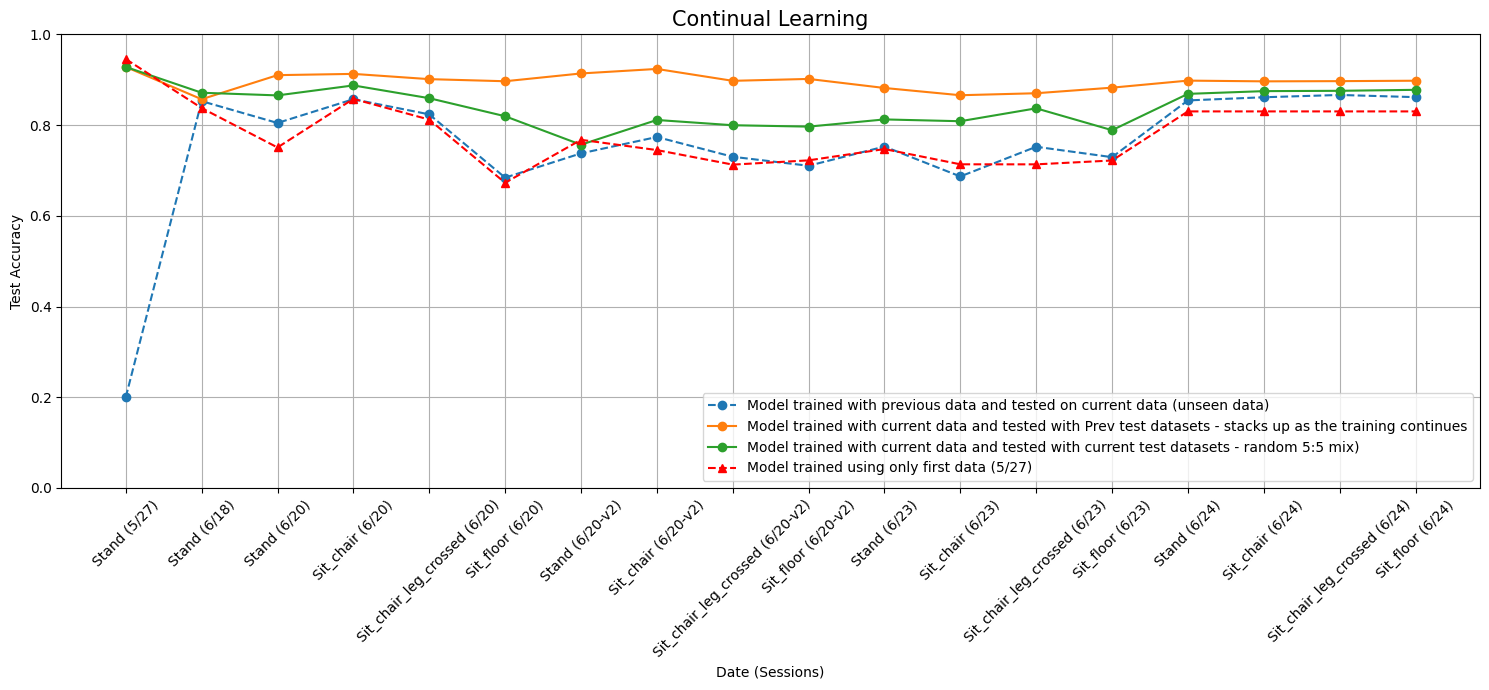

75.21%
89.62%
84.10%


In [3]:
baseline = pd.read_csv('C:/Users/hml76/PycharmProjects/Tremor_project_local/Mindforce/Baseline_results.csv')

plt.figure(figsize=(15, 7))
plt.title('Continual Learning', fontsize=15)

plt.plot(Info, Init_acc_all, marker='o', label='Model trained with previous data and tested on current data (unseen data)', linestyle='--')
plt.plot(Info, Prev_acc_all, marker='o', label='Model trained with current data and tested with Prev test datasets - stacks up as the training continues')
plt.plot(Info, Trained_acc_all, marker='o', label='Model trained with current data and tested with current test datasets - random 5:5 mix)')
plt.plot(Info, baseline['Accuracy']/100, marker='^', label='Model trained using only first data (5/27)', color='red', linestyle='--')

plt.ylim([0, 1])

plt.xlabel('Date (Sessions)')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for x in [Init_acc_all, Prev_acc_all, Trained_acc_all]:
    print(f"{np.mean(x)*100:.2f}%")
